# ch05.08. 기초모델 구현 - Softmax Regression
---
* 날짜: 2022-05-17
* 이름: 고민수

## 학습내용
    - 소프트맥스 회귀 프로세스를 이해한다.
        -소프트맥스 회귀 최적화 이해
    - 소프트맥스 함수를 구현한다.

```
import numpy as np
import matplotlib.pyplot as plt
```

In [37]:
import numpy as np
import matplotlib.pyplot as plt

## 클래스 작성
---

In [80]:
a= np.array([[1,2,3],[1,1,1]])
b= np.array([[1,2,3]])
a+b

array([[2, 4, 6],
       [2, 3, 4]])

In [197]:
num_examples, num_features = np.shape(X_train)
num_classes = y_train.shape[1]

# 가중계수 초기화
_W = np.random.randn(num_features+1, num_classes) / np.sqrt(num_features / 2)

In [72]:
class SoftmaxRegressionGD():

    def __init__(self, lr=0.001, threshold=0.01, random_state=1):
        self.lr=lr
        self.seed = np.random.RandomState(random_state)
        self.threshold=threshold
        
    # 가중치_matrix 설정, X와 y 둘 다 데이터를 받아야함
    def init_weights(self, X, y, show_params=False):
        size = X.shape[1] # 가중치 개수
        y_size = y.shape[1] # 가중치 col
        self.w = self.seed.normal(loc=0.0, scale = 0.01, size=(size, y_size))
        self.b = self.seed.normal(loc=0.0, scale = 0.01, size=y_size)
        if show_params:
            print(f'[info] Initial weights w : {self.w.shape}', self.w, sep='\n')
            print(f'[info] Initial weights b : {self.b}')
        
    # y_hat 만들기 : X*w 를 한 뒤 softmax함수를 통과시킴
    def model(self, X):
        z =  np.dot(X, self.w) + self.b # X*w
        # softmax
        y = np.exp(z) 
        sum_y = np.sum(y, axis=1, keepdims=True)
        return y /sum_y

    # 예측 : 예측한 값중 가장 큰 값의 index를 모음 -> matrix를 vector로 
    def predict(self, X):
        y_hat = self.model(X) # 예측값
        y_pred = np.argmax(y_hat, axis=1)
        return y_pred
    
     # 평가 : loss와 accuracy 값을 모음
    def evaluate(self, X, y):
        y_hat = self.model(X)
        y_pred = self.predict(X)
        loss = self.loss(y, y_hat) # loss 값
        acc = self.accuracy(y, y_pred) # accuarcy 값
        return loss, acc
    
    # loss : log(y_hat) * y_onehot 할 때 shape는 바뀌지 않는다. (여전히 matrix)
    # matrix 내 모든 loss를 더한다.
    def loss(self, y, y_hat):
        N = y.shape[0] # 데이터 개수
        y_hat = np.clip(y_hat, 1e-15, 1.0) # log(0) 방지
        loss = np.log(y_hat[np.arange(y_hat.shape[0]),  np.argmax(y, axis=1)])
        # 소프트맥스(softmax)의 cost(손실함수)
        L = -np.sum(loss)/N
        return L
    
    def gradient_func(self, X, y):
        y_hat = self.model(X)
        N = y.shape[0]
    
        gradient = np.dot(X.T , y_hat_one) / N
        return gradient
    
    # accuracy : y==y_pred 를 y-y_pred=0 으로 예측 성공 여부 확인
    def accuracy(self, y, y_pred):
        y_index = np.argmax(y, axis=1)
        return np.count_nonzero(y_index==y_pred)/len(y)
        # y-y_pred!=0 의 개수를 count 후 len(y)를 나누어 백분율
        
    # 최적화
    def fit(self, X,y, epochs=10, show_params=False):
        
        self.init_weights(X,y) # 가중치 설정
        self.history=dict(loss=[], acc=[]) # loss, acc 값 history.dict 설정
        N = X.shape[0] # N = X의 데이터 개수
        
        for epoch in range(epochs):
            # 최적화
            y_hat = self.model(X) # y_hat
            
            # softmax 손실함수 미분
            self.w -= self.lr*np.dot(X.T , (y_hat-y))/N # 경사하강법에 따른 가중치 설정
            self.b -= self.lr*np.sum(y_hat-y)/N  # 편차_bias(b) 값
            
            # 평가 및 결과 저장
            loss, acc = self.evaluate(X, y)
            self.history['loss'].append(loss)
            self.history['acc'].append(acc)
            if show_params: print(self.w)
                
            # 판정 임계값에 다다르면 학습 중단
            if loss < self.threshold:
                return False
                
            # 100 iter 마다 cost 출력
            if epoch % 100 == 0:
                print(f'[Epoch {epoch}] loss: {np.round(loss,2)}  acc: {np.round(acc,2)}')
            
################## 시각화 #####################

    def draw_dflow(self, X, y, title='', figsize=(8,4)):
        plt.figure(figsize=figsize)
        plt.title(title)

        y_pred = self.predict(X)
        
        plt.plot(np.argmax(y,axis=1) , label='y', marker='o')
        plt.plot(y_pred, label='y_pred', marker='.', linestyle='--')
        plt.legend()
        plt.show()

    # 학습 곡선 시각화
    def draw_lcurve(self, title='', figsize=(8,4)):
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.plot(self.history['acc'], label='acc', marker='o')
        plt.plot(self.history['loss'], label='loss', marker='o')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

## iris 데이터로 분류 진행
---

### **데이터 로드**

In [73]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

def iris_loader(n_class, test_size=0.2, rs=1):
  iris = load_iris()
  X = iris.data
  y = iris.target
  print(X.shape, y.shape, X[0], y[0])
  
  if n_class==2:
    X = X[y!=2]
    y = y[y!=2]
    y = np.where(y==1, 1, 0)
  if n_class==3:
    ohe = OneHotEncoder(sparse=False)
    y = ohe.fit_transform(np.expand_dims(y,1))
  
  X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=rs)
   
  print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
  return X_train, X_test, y_train, y_test

In [74]:
X_train, X_test, y_train, y_test = iris_loader(3)

(150, 4) (150,) [5.1 3.5 1.4 0.2] 0
(112, 4) (38, 4) (112, 3) (38, 3)


### **학습전 성능 평가**

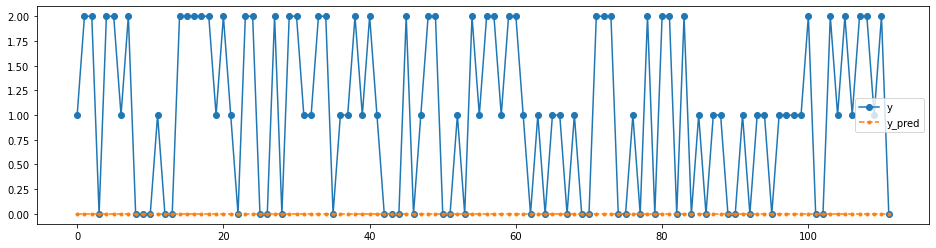

In [75]:
import matplotlib.pyplot as plt

model = SoftmaxRegressionGD(lr=0.1)

model.init_weights(X_train, y_train)
model.draw_dflow(X_train, y_train, figsize=(16,4))

### **학습**

In [76]:
model = SoftmaxRegressionGD(lr=0.1)
model.init_weights(X_train, y_train)
history = model.fit(X_train, y_train, epochs=1000, show_params=False)

[Epoch 0] loss: 1.05  acc: 0.37
[Epoch 100] loss: 0.4  acc: 0.71
[Epoch 200] loss: 0.26  acc: 0.97
[Epoch 300] loss: 0.21  acc: 0.97
[Epoch 400] loss: 0.19  acc: 0.97
[Epoch 500] loss: 0.17  acc: 0.97
[Epoch 600] loss: 0.16  acc: 0.97
[Epoch 700] loss: 0.15  acc: 0.97
[Epoch 800] loss: 0.14  acc: 0.97
[Epoch 900] loss: 0.13  acc: 0.97


### **학습 후 성능평가**

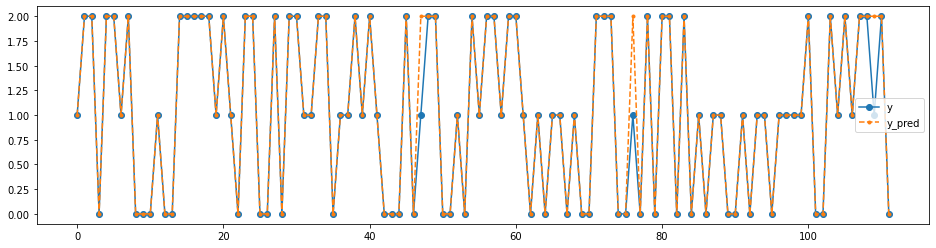

===== lr 0.1 ==== (0.17222448465871096, 0.9473684210526315)


In [77]:
model.draw_dflow(X_train, y_train, figsize=(16,4))
print(f'===== lr {lr} ==== {model.evaluate(X_test, y_test)}')

### **테스트셋 성능평가**

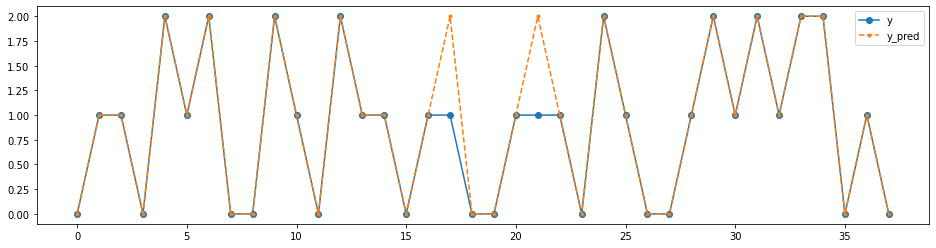

In [78]:
model.draw_dflow(X_test, y_test, figsize=(16,4))

In [79]:
for lr in [0.00001, 0.0001, 0.001, 0.01, 0.1]:
    model = SoftmaxRegressionGD(lr=lr)
    model.init_weights(X_train, y_train)
    history = model.fit(X_train, y_train, epochs=500)
    print(f'===== lr {lr} ==== {model.evaluate(X_test, y_test)}')

[Epoch 0] loss: 1.11  acc: 0.3
[Epoch 100] loss: 1.11  acc: 0.3
[Epoch 200] loss: 1.11  acc: 0.3
[Epoch 300] loss: 1.1  acc: 0.3
[Epoch 400] loss: 1.1  acc: 0.3
===== lr 1e-05 ==== (1.0950644200843997, 0.42105263157894735)
[Epoch 0] loss: 1.11  acc: 0.3
[Epoch 100] loss: 1.09  acc: 0.6
[Epoch 200] loss: 1.08  acc: 0.37
[Epoch 300] loss: 1.07  acc: 0.37
[Epoch 400] loss: 1.06  acc: 0.37
===== lr 0.0001 ==== (1.0792629206311752, 0.23684210526315788)
[Epoch 0] loss: 1.11  acc: 0.3
[Epoch 100] loss: 1.01  acc: 0.37
[Epoch 200] loss: 0.96  acc: 0.62
[Epoch 300] loss: 0.91  acc: 0.7
[Epoch 400] loss: 0.87  acc: 0.7
===== lr 0.001 ==== (0.8790222258113903, 0.5789473684210527)
[Epoch 0] loss: 1.09  acc: 0.37
[Epoch 100] loss: 0.7  acc: 0.7
[Epoch 200] loss: 0.57  acc: 0.71
[Epoch 300] loss: 0.51  acc: 0.8
[Epoch 400] loss: 0.47  acc: 0.84
===== lr 0.01 ==== (0.48603615207738, 0.7368421052631579)
[Epoch 0] loss: 1.05  acc: 0.37
[Epoch 100] loss: 0.4  acc: 0.71
[Epoch 200] loss: 0.26  acc: 0.97
